In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

#All Clustering Algo
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from itertools import cycle
from itertools import combinations

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from scipy.stats.mstats import winsorize
import warnings 

warnings.filterwarnings('ignore')

In [5]:
def clean_data(stocks_df, sector_df, universesize=1003):
    # sector = pd.read_csv("russell1000_sector.csv", error_bad_lines = False)
    sector = sector_df[["Ticker", "GICS Sector"]] 
    
    vars = ['open', 'high', 'low', 'close', 'volume']
    rawdata = {} 
    merged_df = pd.merge(stocks_df, sector[["Ticker", "GICS Sector"]], left_on='ticker', right_on='Ticker', how='left')

    #BASE UNIVERSE: STOCKS IN RUSSELL 1000
    for tvar in vars:
        rawdata[tvar] = merged_df.loc[:, ['tickerid', 'ticker', 'date', tvar]]
        rawdata[tvar] = rawdata[tvar].pivot(index = 'date', columns = 'ticker', values = tvar)
        rawdata[tvar] = rawdata[tvar].iloc[:, :universesize] #universe cap
    
    rawdata_vol = rawdata['volume'].copy()
        
    ######### Check for Trading Volume #########
    # Company level average Volume 
    length = 240 #recent 2 years
    df_vol = rawdata_vol.tail(length)
    
    avg_vol = df_vol.mean(axis=0)
    individual_avg_vol = avg_vol.reset_index()
    individual_avg_vol.rename(columns={0: 'Average Volume'}, inplace=True)
    
    # Sector level average Volume
    d = sector_df.set_index('Ticker').to_dict()
    
    rawdata_vol.columns = rawdata_vol.columns.to_series().map(d['GICS Sector'])
    uniquesector = list(set(rawdata_vol.columns))
        
    sector_avg_vol = {}     
    for tsector in uniquesector:     
        if (str(tsector)=='nan'):
            continue;
#         print(tsector)
        tmean = rawdata_vol.loc[:, tsector].mean(axis=1)
        tmean[~np.isfinite(tmean)] = 0
        sector_mean = tmean.mean()
#         print(sector_mean)
        sector_avg_vol[tsector] = sector_mean  
#     print(sector_avg_vol)
    
        
    # Only keep companies in universe if their average volume > sector average volume 
    final_df = pd.merge(merged_df, individual_avg_vol, on='ticker', how='left')
    
    sector_avg_df = pd.DataFrame(sector_avg_vol, index=[0])
    sector_avg_df = sector_avg_df.transpose()
    sector_avg_df = sector_avg_df.unstack()
    sector_avg_df = (sector_avg_df.reset_index())[['level_1', 0]]
    sector_avg_df.columns = ["Sector", "Sector Average Volume"]
    
    final_df = pd.merge(final_df, sector_avg_df, left_on = 'GICS Sector', right_on='Sector', how='left')
    final_df = final_df[final_df["Average Volume"] >= final_df["Sector Average Volume"]] #not correct yet
    
    # Next step: Run this filtering the day before rebalancing and return a list of filtered tickers
    
    
    return final_df

Affinity Propagation is a clustering algorithm that does not require specifying the number of clusters in advance. It determines the number of clusters based on the data and the input parameters.

eg. AffinityPropagation(damping=0.5, max_iter=200)

Damping Factor: The damping factor controls the level of damping in the affinity updates. It takes a value between 0 and 1. A higher damping factor (closer to 1) dampens the responsibility and availability updates, resulting in fewer cluster assignments and more compact clusters. On the other hand, a lower damping factor (closer to 0) allows more influence from the available exemplars, potentially leading to more clusters and less compactness.

Maximum Number of Iterations: The maximum number of iterations determines the maximum number of iterations the algorithm performs before stopping. If the algorithm has not converged by reaching the maximum number of iterations, it stops and returns the current results. Setting a higher value for the maximum number of iterations allows the algorithm to run for more iterations, potentially refining the clusters further. However, setting a very high value may result in longer execution time, especially for large datasets.

In [6]:
def pairs_identification(df, startdate, enddate):
    df = df.loc[startdate : enddate]
    # Treat missing values
    df = df.fillna(method = "ffill")
    missing_fractions = df.isnull().mean().sort_values(ascending = False)
    drop_list = sorted(list(missing_fractions[missing_fractions > 0].index))
    df.drop(labels= drop_list, axis=1, inplace = True)
    # Generate returns and vol df
    returns = df.pct_change().mean() * 252
    returns = pd.DataFrame(returns)
    returns.columns = ["Returns"]
    returns["Volatility"] = df.pct_change().std() * np.sqrt(252)
    data = returns
    # Scale df
    scaler = StandardScaler().fit(data)
    rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
    X = rescaledDataset
    # Winsorize the df
    X['Returns'] = winsorize(X['Returns'], limits=(0.1, 0.1))
    X['Volatility'] = winsorize(X['Volatility'], limits=(0.1, 0.1))
    
    # Clustering using Affinity Propogation
    ## It is recommended to apply the algorithm to a subset of your data or use dimensionality reduction techniques if needed.
    # ap = AffinityPropagation() 

    ##Can try tuning here (Higher damping factors may lead to fewer clusters but more compact clusters, 
    ##while lower damping factors may result in more clusters but less compactness.)
    ap = AffinityPropagation(damping=0.9, max_iter=200)  
    ap.fit(X)

    ''' Access the objective function values during iterations (additional)
    obj_func = clustering.history_['objective']

    # Plot the objective function values
    plt.plot(np.arange(len(obj_func)), obj_func)
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.title('Affinity Propagation - Convergence')
    plt.show()
    '''

    clust_labels2 = ap.predict(X)

    # clustered stock with its cluster label
    cluster_centers_indices = ap.cluster_centers_indices_  #coordinates of the identified cluster centers
    labels = ap.labels_  #assigned cluster labels for each sample
    clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
    # Identify closest pair in each cluster
    final_pairs = []
    
    for i in range(0,clustered_series_ap.max() + 1):
        clustered_stocks = clustered_series_ap[clustered_series_ap == i]
        stock_pairs = list(combinations(clustered_stocks.index, 2))
    
        # Comb through and select only cointegrated pairs
        cointegrated_pairs = []
        threshold = 0.1  #I think a bit lenient, can try 0.05 or 0.025
        for pair in stock_pairs:
            df2 = df[list(pair)]
            score, pvalue, _ = coint(df2.values[:,0], df2.values[:,1])
            if pvalue < threshold:
                cointegrated_pairs.append(pair)

        # Identify pair in each cluster with shortest Gatev distance measure 
        spread_dict = {}
        for pair in cointegrated_pairs:
            S1 = list(pair)[0]
            S2 = list(pair)[1]
            df2 = df[list(pair)]
            S1_final = df2[S1][-1]
            S2_final = df2[S2][-1]
            df2[S1] = df2[S1] / S1_final
            df2[S2] = df2[S2] / S2_final
            df2["spread"] = (df2[S1] / df2[S2]) -1
            mean_spread = df2["spread"].mean()
            hist_dist = ((df2["spread"] - mean_spread) ** 2).sum()
            spread_dict[pair] = hist_dist
        final_pairs.append(min(spread_dict, key = spread_dict.get))
    
    return final_pairs

In [8]:
snp500.head()

,date,gvkey,iid,tic,cusip,company name,volume,close,high,low,open,exchg
0,2000-01-03,1045,1,AAMRQ,001765106,AMERICAN AIRLINES GROUP INC,566200.0,67.3750,67.8125,66.1875,NaN,19
1,2000-01-04,1045,1,AAMRQ,001765106,AMERICAN AIRLINES GROUP INC,811800.0,65.8750,68.5625,65.6250,NaN,19
2,2000-01-05,1045,1,AAMRQ,001765106,AMERICAN AIRLINES GROUP INC,665500.0,63.8125,65.5000,63.3750,NaN,19
3,2000-01-06,1045,1,AAMRQ,001765106,AMERICAN AIRLINES GROUP INC,1034300.0,62.1250,64.1875,62.0625,NaN,19
4,2000-01-07,1045,1,AAMRQ,001765106,AMERICAN AIRLINES GROUP INC,662100.0,63.6875,64.1250,62.1250,NaN,19


In [7]:
# S&P500 data
snp500 = pd.read_csv("snp500_daily_prices_volume.csv")
snp500['date'] = pd.to_datetime(snp500['date'], format='%d/%m/%Y')
df = snp500.pivot(index = "date", columns = "tic", values = "close")

df = pairs_identification(df, '2000-01-01','2000-12-31')
df

[('NEBLQ.1', 'RIG'),
 ('FOSL', 'GEN'),
 ('MOLX', 'MOLXA'),
 ('SNV', 'TFC'),
 ('COST', 'ETFC'),
 ('TXT', 'TXT.PB'),
 ('BRL', 'GILD'),
 ('ITW', 'JCI'),
 ('CMVT', 'PTC'),
 ('AVB', 'BXP'),
 ('JBL', 'MFE'),
 ('FML', 'MPF.'),
 ('ACS', 'FJ'),
 ('CCI', 'HOLX'),
 ('CAM', 'DOFSQ'),
 ('PNC.PC', 'PNC.PD'),
 ('AYE', 'TE'),
 ('MXIM', 'XLNX'),
 ('AMSGB', 'EVHC'),
 ('CMCSK', 'ODFL'),
 ('NAV.PD', 'NKM.1'),
 ('EQR', 'EQR.PE'),
 ('PARA', 'PARAA')]

In [ ]:
#Russell1000 data
russell_df = pd.read_csv("russell1000pvdata.csv", error_bad_lines = False)  #use larger cap companies
russell_sector_df = pd.read_csv("russell1000_sector.csv", error_bad_lines = False)
rawdata = clean_data(russell_df, russell_sector_df).copy(deep=True)

rawdata['date'] = pd.to_datetime(rawdata['date'], format='%Y%m%d')
rawdata['date'] = rawdata['date'].dt.strftime('%Y-%m-%d')  #To match with alvin's format

rawdata = rawdata.pivot(index = 'date', columns = 'ticker', values = 'close')
rawdata.dropna(axis=0, thresh=7, inplace=True)

In [ ]:
len(rawdata)

2517

In [ ]:
# full date range ('2010-12-27','2020-12-23')
# russell1000_pairs = pairs_identification(rawdata, '2010-12-27','2020-12-23')
russell1000_pairs = pairs_identification(rawdata, '2011-01-01','2011-12-31')
russell1000_pairs

[('NI', 'TJX'),
 ('C', 'MS'),
 ('ABT', 'MO'),
 ('BK', 'SCHW'),
 ('GPK', 'LYB'),
 ('AES', 'OXY'),
 ('MPW', 'VNO'),
 ('IVZ', 'KEY'),
 ('AMT', 'NKE'),
 ('O', 'VTR'),
 ('HRB', 'WMB'),
 ('LUMN', 'WM'),
 ('PEP', 'T')]

In [ ]:
pair_list = []
for i, j in russell1000_pairs:  
    pair_list.append(i)
    pair_list.append(j)

russell1000_pairs_df = rawdata[pair_list].loc['2011-01-01':'2011-12-31']

In [ ]:
return_df = russell1000_pairs_df.pct_change()
# return_df.head()

# Consistency Check using Correlation

(1) Shortlist pairs with high $R^{2}$  
(2) OLS beta = Hedge Ratio
(3) $R^{2}$ of OLS regression with a single independent variable and intercept term $\equiv \rho^{2}_{x_{1,t}, x_{2,t}}$
(4) The intercept term is the average distance between both legs 

In [ ]:
pairs_corr = return_df.corr()
# pairs_corr

In [ ]:
russell1000_pairs_df

ticker,NI,TJX,C,MS,ABT,MO,BK,SCHW,GPK,LYB,...,O,VTR,HRB,WMB,LUMN,WM,PEP,T,C_lag_1,MS_lag_1
date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,7.017682,10.895000,49.000000,28.469999,23.159946,24.389999,30.629999,17.219999,4.03,34.869999,...,33.889999,60.751400,12.30,20.005009,46.730000,36.599998,65.410004,29.879999,49.000000,28.230000
2011-01-05,7.045187,10.750000,49.700001,28.830000,23.159946,24.480000,31.690001,18.080000,4.10,34.849998,...,33.860001,60.260365,12.59,20.037617,46.389999,36.580002,66.589996,29.980000,49.000000,28.469999
2011-01-06,7.041257,11.380000,49.500000,28.799999,23.111965,24.580000,31.440001,17.969999,4.06,34.970001,...,33.630001,60.203266,12.59,19.996857,45.439999,36.410000,66.839996,29.150000,49.700001,28.830000
2011-01-07,7.155206,11.412500,49.400002,28.200001,23.207926,24.389999,30.760000,17.889999,4.15,34.619999,...,33.810001,59.849262,12.78,20.314783,44.810001,36.209999,66.389999,28.850000,49.500000,28.799999
2011-01-10,7.108055,11.395000,49.099998,28.049999,23.001612,24.240000,30.700001,17.950001,4.22,35.240002,...,33.709999,59.403904,12.66,20.176201,44.959999,36.150002,66.050003,28.340000,49.400002,28.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-23,9.202358,16.327499,27.459999,15.760000,26.878395,29.840000,20.080000,11.540000,4.30,32.990002,...,35.250000,62.738380,16.08,26.665192,37.099998,32.730000,66.570000,29.870001,27.650000,15.880000
2011-12-27,9.296660,16.344999,26.900000,15.290000,26.979155,29.719999,19.980000,11.520000,4.27,32.970001,...,35.590000,63.229416,16.00,26.754864,37.160000,32.849998,66.379997,30.040001,27.459999,15.760000
2011-12-28,9.288802,16.209999,26.129999,14.900000,26.787233,29.719999,19.580000,11.230000,4.12,32.250000,...,35.060001,62.772640,15.87,26.192375,36.669998,32.410000,65.910004,29.950001,26.900000,15.290000


In [ ]:
watchlist_pairs = []
spread_df = pd.DataFrame()

for i in range(len(russell1000_pairs)):
    X = sm.add_constant(russell1000_pairs_df[russell1000_pairs[i][0]])
    model = sm.OLS(russell1000_pairs_df[russell1000_pairs[i][1]], X)
    results = model.fit()
    
    if (results.rsquared > 0.9):
        # print(results.summary())
        watchlist_pairs.append(russell1000_pairs[i])

        print("Hedge Ratio (Beta) =", round(results.params[russell1000_pairs[i][0]], 3), "for", russell1000_pairs[i])
        print("Average Distance (Spread) between pair =", round(results.params['const'], 3))
        print(pairs_corr[list(russell1000_pairs[i])].loc[list(russell1000_pairs[i])])
        print("\n")

        spread_df["pair_{0}".format(i)] \
        = russell1000_pairs_df[russell1000_pairs[i][1]] - results.params[0] \
        - results.params[1]* russell1000_pairs_df[russell1000_pairs[i][0]]

print(len(watchlist_pairs), "pairs with R-squared > 0.9 are: ", watchlist_pairs)

Hedge Ratio (Beta) = 0.652 for ('C', 'MS')
Average Distance (Spread) between pair = -2.589
ticker        C       MS
ticker                  
C       1.00000  0.87136
MS      0.87136  1.00000


Hedge Ratio (Beta) = 0.614 for ('BK', 'SCHW')
Average Distance (Spread) between pair = -0.172
ticker        BK      SCHW
ticker                    
BK      1.000000  0.794436
SCHW    0.794436  1.000000


Hedge Ratio (Beta) = 5.26 for ('MPW', 'VNO')
Average Distance (Spread) between pair = 5.947
ticker       MPW       VNO
ticker                    
MPW     1.000000  0.862244
VNO     0.862244  1.000000


Hedge Ratio (Beta) = 0.308 for ('IVZ', 'KEY')
Average Distance (Spread) between pair = 1.119
ticker       IVZ       KEY
ticker                    
IVZ     1.000000  0.822213
KEY     0.822213  1.000000


4 pairs with R-squared > 0.9 are:  [('C', 'MS'), ('BK', 'SCHW'), ('MPW', 'VNO'), ('IVZ', 'KEY')]


In [ ]:
spread_df.tail()

,pair_1,pair_3,pair_6,pair_7
date,,,,
2011-12-23,0.438650,-0.614348,-2.187231,0.433635
2011-12-27,0.333891,-0.572962,-2.725050,0.420590
2011-12-28,0.446100,-0.617415,-2.184294,0.453012
2011-12-29,0.375202,-0.848210,-2.108538,0.460590
2011-12-30,0.558701,-0.789991,-1.626487,0.383669


In [ ]:
spread_df[["pair_1"]]

,pair_1
date,
2011-01-03,-1.140135
2011-01-04,-0.900136
2011-01-05,-0.996688
2011-01-06,-0.896245
2011-01-07,-1.431022
...,...
2011-12-23,0.438650
2011-12-27,0.333891
2011-12-28,0.446100


### Check for Stationarity of Spread (Mean Reversion)

To check for stationarity of the spread in pairs trading, you can use statistical tests such as the Augmented Dickey-Fuller (ADF) test or the Phillips-Perron (PP) test. These tests help determine if a time series is stationary or exhibits a unit root, indicating non-stationarity. (The stationarity of the spread is an indication of a potential cointegrated relationship between the two stocks, but the individual stocks may still exhibit non-stationary behavior.)

In [ ]:
# Perform ADF test on the first watchlist pair
result = sm.tsa.stattools.adfuller(spread_df["pair_1"])

# Extract ADF test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Print ADF test results
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("Critical Values:")
for key, value in critical_values.items():
    print("{}: {}".format(key, value))

ADF Statistic: -3.611449931509699
p-value: 0.005545865008545693
Critical Values:
1%: -3.4566744514553016
5%: -2.8731248767783426
10%: -2.5729436702592023


The more negative (or less positive) the ADF statistic, the stronger the evidence against the null hypothesis of non-stationarity. If the ADF statistic is more negative than the critical values, it suggests rejecting the null hypothesis in favor of stationarity.

p-value: The p-value is the probability of observing the given ADF statistic if the null hypothesis is true (i.e., if the time series is non-stationary). A lower p-value suggests stronger evidence against the null hypothesis of non-stationarity. Typically, if the p-value is less than a predetermined significance level (e.g., 0.05), the null hypothesis is rejected, indicating stationarity.

# Cointegration

It relates to the long-term equilibrium relationship between 2 or more non-stationary time series variables. It measures how 2 or more variables move together over time, despite possibly having short-term fluctuations or differences. Cointegration is typically assessed using statistical tests, such as the Engle-Granger test or the Johansen test. (These tests evaluate the presence of a linear combination of the stock prices or returns that is stationary over time.)

> Key Idea: Even though the individual variables may have their own short-term fluctuations, there exists a linear combination of these variables that is stationary => it has a constant mean and does not exhibit trends. 

Stationarity of the spread is a necessary condition for cointegration, but it is not sufficient. Cointegration requires a long-term equilibrium relationship between the stocks, and the spread being stationary suggests that any deviations from this equilibrium will be corrected over time.

Additionally, it is important to consider other factors and conduct further analysis to validate the cointegrated relationship. This may include assessing the economic or fundamental relationship between the stocks, considering the time frame and sample size of the data, and evaluating the stability of the relationship over different periods.

In [ ]:
#Testing with 1 pair russell1000_pairs_df[["C", "MS"]]

stock1 = russell1000_pairs_df['C']
stock2 = russell1000_pairs_df['MS']

# Perform the Engle-Granger test for cointegration
result = coint(stock1, stock2)

# Extract the test statistic, p-value, and critical values
test_statistic = result[0]
p_value = result[1]
critical_values = result[2]

# Print the test results
print('Test Statistic:', test_statistic)
print('P-value:', p_value)
print('Critical Values:', critical_values)


Test Statistic: -3.6531297978770376
P-value: 0.02102693777309062
Critical Values: [-3.94060523 -3.36058133 -3.06139039]


- If the p-value is less than the significance level (e.g., p-value < 0.05), you can conclude that there is strong evidence of cointegration between the two stocks. This suggests that the pair of stocks has a long-term equilibrium relationship, and any deviations from this equilibrium will be corrected over time.

> If conintegrating relationship exists, residuals will be judged as stationary and we will estimate an ECM as the best predictive model for Y in terms of X.

ECM: $\triangle Y_t = \gamma + \beta_1 \triangle X_t + \alpha(Y_{t-1} - \beta_0 - \beta_1 X_{t-1}) + v_t$

Focusing on the transient term (i.e. regressing against lagged variables only)

In [ ]:
# Create the lagged variables
russell1000_pairs_df['C_lag_1'] = russell1000_pairs_df['C'].shift(1)
russell1000_pairs_df['MS_lag_1'] = russell1000_pairs_df['MS'].shift(1)
russell1000_pairs_df.dropna(inplace=True)

y = russell1000_pairs_df['C']
X = russell1000_pairs_df[['C_lag_1', 'MS_lag_1']]
X = sm.add_constant(X)

# Create the Error Correction Model (ECM)
model = sm.OLS(y, X)
results = model.fit()
ecm_coefficients = results.params
residuals = results.resid  #ECT

# Print the ECM coefficients
print(ecm_coefficients)

const       0.414290
C_lag_1     0.941976
MS_lag_1    0.076387
dtype: float64


 The error correction term (ECT) is implicitly captured by the coefficients of the lagged variables in the model. In an ECM, the ECT represents the speed of adjustment towards the long-term equilibrium relationship. It is typically calculated as the residual from regressing the dependent variable on its lagged values and the lagged independent variables. The coefficient associated with the lagged dependent variable in this regression captures the impact of the error correction term on the dependent variable.

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      C   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     7889.
Date:                Sat, 10 Jun 2023   Prob (F-statistic):          3.26e-225
Time:                        14:41:06   Log-Likelihood:                -368.09
No. Observations:                 251   AIC:                             742.2
Df Residuals:                     248   BIC:                             752.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4143      0.363      1.141      0.2

- When the error correction term in an Error Correction Model (ECM) is positive, it suggests that there is a tendency for the variables to adjust towards their long-term equilibrium relationship. This implies that if the variables deviate from their equilibrium, the error correction term will act to bring them back in line. 

- When the error correction term in an Error Correction Model (ECM) is negative, it suggests that there is a tendency for the variables to move further away from their long-term equilibrium relationship. This implies that if the variables deviate from their equilibrium, the error correction term will act to amplify the deviation.

- The positive ECT indicates that there is a restorative force pushing the variables back towards their equilibrium when they diverge. As the variables deviate from their equilibrium, the positive ECT implies that they will gradually adjust to reduce the deviation over time. However, the exact speed and path of convergence can be influenced by various factors, including market dynamics, trading volumes, liquidity, and other market participants' actions.

<AxesSubplot: xlabel='date'>

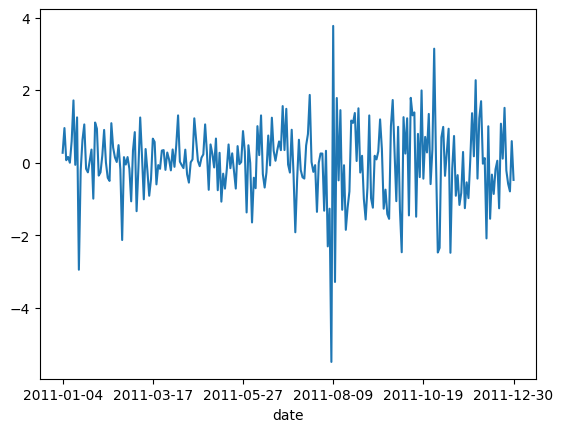

In [ ]:
#These residuals represent the error correction term, 
#capturing the deviation from the long-term equilibrium relationship between the two stocks.
residuals.plot()

In [ ]:
# Calculate the spread between the two stocks
# spread = russell1000_pairs_df['C'] - residuals * russell1000_pairs_df['MS']

# Distance Measure

Some commonly used distance measures include Euclidean distance, correlation distance, or normalized distance measures like z-score or percent change.